In [ ]:
# !pip install HDBSCAN

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.core.display import HTML, display
import time
from typing import Callable, Union

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN
from scipy.spatial.distance import squareform, pdist
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
colors = ['lightpink','deepskyblue','orange', 'lime',
          'magenta','yellow','green','red','powderblue']

pypat_vanja = ListedColormap(colors)
matplotlib.style.use('default')

In [ ]:
# Fix seed
seed = 42069
np.random.seed(seed)

# Task 1 - Data analysis and preprocessing

>"The datasets contains information on 20,000 blood cells of 20 rheumatoid arthritis patients and 20 healthy controls. The first two columns identify the patient and the patient group. The remaining columns are the cell markers measured." - Project text


In [ ]:
# Import the data
df_raw = pd.read_csv('cell_data.csv')
df = df_raw.copy()

### Inspecting the raw data

Sampling 10 random samples without replacement to inspect the features and values. 


In [7]:
n_data, n_features = df.shape[0], df.shape[1]
print(f'There are in total {n_data} data points')
print(f'There are in total {n_features} features')

There are in total 800000 data points
There are in total 14 features


In [ ]:
def print_html(df: pd.DataFrame):
    '''Display give DataFrame as HTML table'''
    display(HTML(df.to_html()))

In [9]:
print_html(df.sample(10, random_state=seed))

,id,group,147Sm_CD20,170Er_CD3,145Nd_CD4,146Nd_CD8a,169Tm_CD45RA,176Yb_CD56,148Nd_CD16,160Gd_CD14,209Bi_CD61,159Tb_CD11c,151Eu_CD123,174Yb_HLA-DR
247691,13,diseased,0.0,19.179001,0.000000,158.615997,0.000000,0.000000,0.000,0.00,0.000,0.000,0.000,4.119
256297,13,diseased,0.0,276.653992,1.169000,258.928986,96.736000,25.469999,0.000,0.00,0.000,2.950,0.411,1.341
92005,5,diseased,0.0,120.935997,30.316000,2.878000,10.205000,0.000000,0.000,0.00,0.000,1.604,0.000,0.000
771062,39,control,0.0,142.511002,37.345001,10.302000,0.000000,0.514000,0.000,0.00,2.705,0.000,0.000,0.000
354253,18,diseased,0.0,189.509003,0.000000,125.862999,1.509000,0.000000,0.000,0.00,0.000,0.000,0.000,0.898
166902,9,diseased,0.0,95.462997,0.000000,210.440002,408.962006,0.000000,0.000,0.00,0.964,0.000,0.000,0.000
357247,18,diseased,0.0,122.242996,0.000000,107.801003,314.273987,2.511000,0.000,5.63,0.000,0.000,0.000,0.000
748067,38,control,0.0,111.741997,14.804000,1.569000,6.872000,0.000000,0.000,0.00,0.000,0.000,0.000,0.000
221044,12,diseased,0.0,0.051000,0.000000,0.966000,146.117996,38.518002,0.215,0.00,0.000,0.000,0.000,2.419
778558,39,control,0.0,343.322998,38.271999,0.000000,0.000000,0.000000,0.000,0.00,0.000,0.000,0.000,0.810


**The id**: The *id* column is simply the test subject's identification number, which should not have any role in representing the data. The *id* column will be omitted from as it will not contribute to the analysis. 

**Sparse columns**: Some columns such as *147Sm_CD20* and *148Nd_CD16* are very sparse. For this context, the samples are individual blood cells, which can of course consists of several different types of cells with different markers. 

**The labels**: The analysis is focused on the revealing differences that separates healthy and diseased people. The label for each data-point is then *control* or *diseased*, which will then be converted to numerical labels 0 and 1 respectively for ease of use.

In [10]:
print_html(df.describe())

,id,147Sm_CD20,170Er_CD3,145Nd_CD4,146Nd_CD8a,169Tm_CD45RA,176Yb_CD56,148Nd_CD16,160Gd_CD14,209Bi_CD61,159Tb_CD11c,151Eu_CD123,174Yb_HLA-DR
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,20.500000,1.071812,116.282667,14.654339,66.665835,66.690869,13.648552,0.604842,5.170937,19.251019,22.061555,1.067191,50.594894
std,11.543404,6.750842,107.193409,19.038641,176.118600,125.797889,56.528820,16.301034,19.063708,90.727504,70.124454,8.362124,156.139429
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.750000,0.000000,1.104000,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.500000,0.000000,111.097000,2.326000,1.954000,10.253000,0.109000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,30.250000,0.000000,187.037003,28.202000,17.595500,79.177252,3.168000,0.000000,0.000000,0.563000,2.048000,0.000000,5.779000
max,40.000000,3248.843994,1093.625000,2426.083008,34624.800781,6391.654785,2526.949951,8545.107422,910.487976,31042.130859,2897.091064,466.604004,17494.880859


The basic feature-wise statistics varies quite a bit, where some features (excluded id) ranges between 0 and 500, and some other between 0 and 35000. The suggested scaling of arcsinh(x/5) will be done to the features.

# Task 1 - Preprocessing

In [11]:
# Encode string labels to numerical
labelencoder = LabelEncoder()
df.group = labelencoder.fit_transform(df['group'])
print(df.sample(10, random_state=seed).group)

247691    1
256297    1
92005     1
771062    0
354253    1
166902    1
357247    1
748067    0
221044    1
778558    0
Name: group, dtype: int64


Looks good!

In [12]:
print_html(df.head())

,id,group,147Sm_CD20,170Er_CD3,145Nd_CD4,146Nd_CD8a,169Tm_CD45RA,176Yb_CD56,148Nd_CD16,160Gd_CD14,209Bi_CD61,159Tb_CD11c,151Eu_CD123,174Yb_HLA-DR
0,1,0,0.000,131.332001,35.242001,5.460,13.194000,0.000,0.0,0.0,0.000,0.00,0.0,0.0
1,1,0,0.000,442.416992,34.754002,0.000,199.770996,0.000,0.0,0.0,0.000,1.06,0.0,0.0
2,1,0,0.489,252.893005,38.896000,1.158,115.276001,0.605,0.0,0.0,1.077,0.00,0.0,0.0
3,1,0,0.000,438.648987,43.154999,3.116,56.352001,0.000,0.0,0.0,0.000,0.00,0.0,0.0
4,1,0,0.000,195.774002,16.608999,0.000,3.942000,0.000,0.0,0.0,0.000,0.00,0.0,0.0


Do the arcsinh(x/5) scaling that was mentioned above

In [ ]:
df[df.columns[2:]] = np.arcsinh(df[df.columns[2:]] / 5)

In [14]:
# Sanity check
print_html(df.head())

,id,group,147Sm_CD20,170Er_CD3,145Nd_CD4,146Nd_CD8a,169Tm_CD45RA,176Yb_CD56,148Nd_CD16,160Gd_CD14,209Bi_CD61,159Tb_CD11c,151Eu_CD123,174Yb_HLA-DR
0,1,0,0.000000,3.961800,2.650942,0.944955,1.697582,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
1,1,0,0.000000,5.175994,2.637139,0.000000,4.381038,0.000000,0.0,0.0,0.000000,0.210443,0.0,0.0
2,1,0,0.097645,4.616773,2.748706,0.229578,3.831509,0.120707,0.0,0.0,0.213768,0.000000,0.0,0.0
3,1,0,0.000000,5.167441,2.851847,0.588617,3.117289,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
4,1,0,0.000000,4.360833,1.915577,0.000000,0.723585,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


### Create subsample
In order to reduce runtimes, a subsample is created that will be used for visualization and clustering. The subsample will contain 20 000 samples, meaning 500 cells per patient (stratified random sample). The subsample size may be significantly reduced relative to the full dataset (from 20 000 cells per person to 500), but should still be representative of the data in general. 

In [15]:
# Stratified subsample by id
cells_per_person = 500

df_sub = df.groupby(by='id', group_keys=False).apply(
    lambda idgroup: idgroup.sample(n=cells_per_person, random_state=seed))

n_data_sub = len(df_sub)
print(f'Number of subsamples: {n_data_sub}')

Number of subsamples: 20000


In [ ]:
# Shuffle
df = df.sample(frac=1, random_state=seed)
df_sub = df_sub.sample(frac=1, random_state=seed)

Extract the *id* column from the dataset (reason mentioned above)

In [ ]:
ids = df['id'].values.copy()
ids_sub = df_sub['id'].values.copy()

df.drop(columns='id', inplace=True)
df_sub.drop(columns='id', inplace=True)

## Univariate statistics of preprocessed data

The numbers have changed as a product of the scaling. The standard deviations are significantly lower and naturally the range of the features as well. The means are much closer to zero than before.


In [18]:
display(HTML(df.describe().to_html()))

,group,147Sm_CD20,170Er_CD3,145Nd_CD4,146Nd_CD8a,169Tm_CD45RA,176Yb_CD56,148Nd_CD16,160Gd_CD14,209Bi_CD61,159Tb_CD11c,151Eu_CD123,174Yb_HLA-DR
count,800000.0,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.5,0.118724,2.814926,1.149186,1.333008,1.877454,0.605289,0.085733,0.306969,0.488388,0.671586,0.095757,0.983693
std,0.5,0.418637,1.906296,1.220869,1.837691,1.754363,1.114371,0.283685,0.851867,1.220928,1.358012,0.386090,1.685285
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.219044,0.000000,0.000000,0.029996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.5,0.000000,3.794619,0.449871,0.381480,1.466038,0.021798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,0.000000,4.315194,2.430869,1.970954,3.456394,0.597422,0.000000,0.000000,0.112363,0.398934,0.000000,0.987367
max,1.0,7.169764,6.080968,6.877744,9.536035,7.846458,6.918479,8.136824,5.897698,9.426810,7.055172,5.229219,8.853373


As expected from the task description, the distribution between the classes (control or diseased) is perfectly even, thus we have perfectly a balanced dataset both with respect to patient group and sample count per patient.

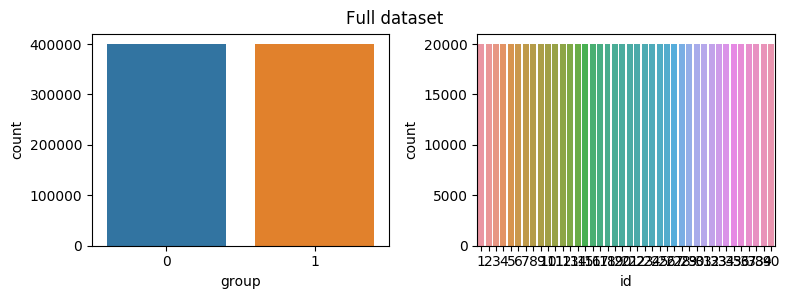

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
sns.countplot(df.group, ax=axes[0])
sns.countplot(pd.DataFrame(ids, columns=['id']).id, ax=axes[1])
fig.suptitle('Full dataset')
fig.tight_layout(rect=(0,0,1,0.95))
plt.show()

Since the full dataset is perfectly uniform both in terms of control/diseased and id, the subsample is definetively the same as it is a stratified subsample. As a sanity check, the plot of the distributions is shown below.

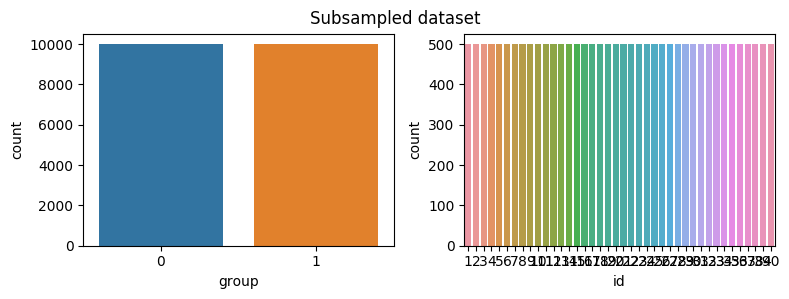

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
sns.countplot(df_sub.group, ax=axes[0])
sns.countplot(pd.DataFrame(ids_sub, columns=['id']).id, ax=axes[1])
fig.suptitle('Subsampled dataset')
fig.tight_layout(rect=(0,0,1,0.95))
plt.show()

## Bivariate statistics

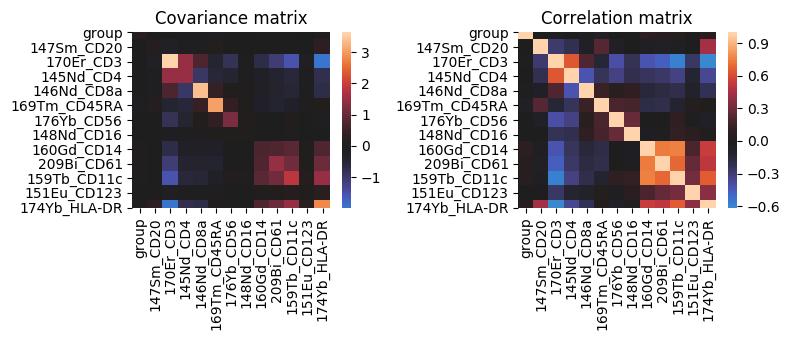

In [21]:
covmat = df.cov()
cormat = df.corr()

fig, axes = plt.subplots(1, 2, figsize=(8,3.5))
sns.heatmap(covmat, ax=axes[0], center=0)
sns.heatmap(cormat, ax=axes[1], center=0)
axes[0].set_title('Covariance matrix')
axes[1].set_title('Correlation matrix')
fig.tight_layout(rect=(0,0,1,1))
plt.show()

Get the 3 pairs of features with highest correlations

In [ ]:
abscormat = cormat.abs()
triabscormat = abscormat.where(np.triu(np.ones(abscormat.shape), k=1).astype(bool)).stack()

In [23]:
print(list(triabscormat.sort_values(ascending=False).index[:3]))

[('160Gd_CD14', '159Tb_CD11c'), ('160Gd_CD14', '209Bi_CD61'), ('209Bi_CD61', '159Tb_CD11c')]


In [24]:
viz_features = np.unique(list(triabscormat.sort_values(ascending=False).index[0:3]))
print(viz_features)

['159Tb_CD11c' '160Gd_CD14' '209Bi_CD61']


The top 3 pairs actually only consists of 3 unique features! This means that we can visualize the features. Since the 3 features has correlations, we should be able to see some kind of patterns by visualizing the features (as apposed to noise).

# Visualizing the data

### Helper functions for visualization

In [ ]:
def scatter2d3d(df, theta=(45,45), aspect_equal: bool = False, figsize: tuple = (12,4), *args, **kwargs) -> tuple:
    '''
    Given a dataframe with at least three columns, scatterplot the data on a 3D axes object as well as 
    all the 2D projections of the axes. The columns names of the dataframe will be used as axes names.  
    '''
    X = df.values
    fnames = df.columns 

    # Create figure and axes
    fig = plt.figure(figsize=figsize)    
    axes = [fig.add_subplot(141, projection='3d'), fig.add_subplot(142), fig.add_subplot(143), fig.add_subplot(144)]  

    axes[0].scatter(*X[:,[0,1,2]].T, *args, **kwargs)
    axes[1].scatter(*X[:,[0,1]].T, *args, **kwargs)
    axes[2].scatter(*X[:,[1,2]].T, *args, **kwargs)
    axes[3].scatter(*X[:,[0,2]].T, *args, **kwargs)
    
    axes[0].view_init(*theta)
    plt.setp(axes[0], xlabel=fnames[0], ylabel=fnames[1], zlabel=fnames[2])
    plt.setp(axes[1], xlabel=fnames[0], ylabel=fnames[1])
    plt.setp(axes[2], xlabel=fnames[1], ylabel=fnames[2])
    plt.setp(axes[3], xlabel=fnames[0], ylabel=fnames[2])
    
    [ax.grid() for ax in axes]
    if aspect_equal:
        [ax.set_aspect('equal') for ax in axes]

    fig.tight_layout()
    return fig, axes

### Separate data and labels as numpy arrays


In [ ]:
# Separate data and labels for conventional purposes
X, y = df.values[:,1:], df.group.values.flatten()
X_sub, y_sub = df_sub.values[:,1:], df_sub.group.values.flatten()

In [27]:
# Sanity check (also updates n_data, n_features from previously)
n_data, n_features = X.shape[0], X.shape[1]
n_data_sub = X_sub.shape[0]
print(f'There are {n_data} data points')
print(f'There are {n_features} features')
print(f'There are {n_data_sub} data points in subsample')

There are 800000 data points
There are 12 features
There are 20000 data points in subsample


Visualizing the subset in order to reduce clutter and computation 


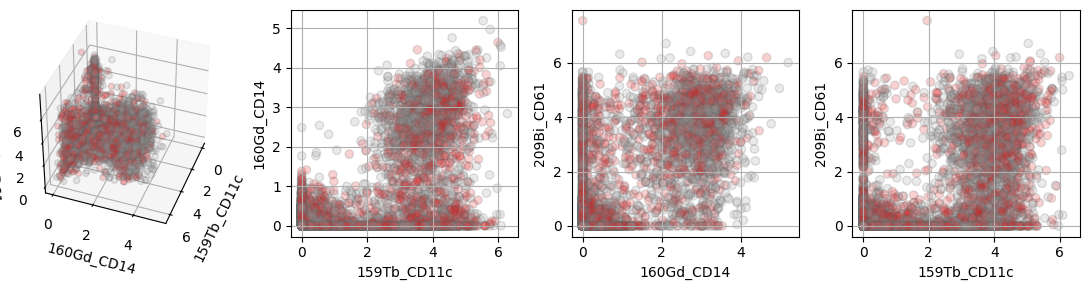

In [28]:
scatter2d3d(df_sub[viz_features], (40,20), c=y_sub, figsize=(11,3), edgecolor='dimgrey', cmap='Set1', alpha=0.2)
plt.show()

The features does indeed show some kind of shapes here. In the first 2D scatterplot that plots 160GD_CD14 and 159Tb_CD11c markers shows something that is maybe of interest. The top left is relatively pure for one class.

# Task 2 - Dimensionality Reduction

The Dimensionality Reduction algorithms that are going to be applied on the data are:
- UMAP
- LLE
- PCA

The motivation here is to represent the data using algorithms that are very different from each other. UMAP is essentially doing a kind of spring system simulation on the data, LLE is a attempting to reconstruct points with a linear combination of the points' neighbors, while PCA is a matrix factorization method. UMAP is the one particularily designed to represent data in visualizable dimensions. 

In [ ]:
def name(obj) -> str:
    '''Get string name of obj, works for functions and instances'''
    return obj.__name__ if isinstance(obj, Callable) else obj.__class__.__name__

In [ ]:
def get_visualizations(X: np.ndarray, visualizers: list, show: bool=False) -> dict:
    '''
    Takes in X and returns a list of all visualizeres from Sklearn-API visualization
    (e.g. UMAP) algorithms. Visualizers should be allocated objects. Returns a dicitonary
    with the names of the visualizers and the values are the result from said visualizer.
    '''
    transforms = dict()
    for viz in visualizers:
        algoname = name(viz)
        t0 = time.time()
        print(f'Running {algoname}', end='')
        transforms[algoname] = viz.fit_transform(X)
        print(f'\r{algoname} transformed in {time.time()-t0:.2f} seconds')

    print()
    return transforms

In [ ]:
def show_visualizations(vizzes: dict, y: np.ndarray, title=None, **kwargs) -> None:
    '''
    Takes in a dictionary where keys are name of an algroithm, e.g UMAP and the corresponding
    value is 2D plot data.
    '''
    n_viz = len(vizzes)
    
    fig, axes = plt.subplots(1, n_viz, figsize=(8, 0.8*n_viz))
    
    for ax, name, X in zip(axes, vizzes.keys(), vizzes.values()):
        ax.scatter(*X.T, c=y, **kwargs)
        ax.set_title(name)
    
    if title:
        fig.suptitle(title)
        fig.tight_layout(rect=(0,0,1,0.90))
    else:
        fig.tight_layout()

    plt.show()

The data is going to be represented in two dimensions. UMAP and LLE has additional hyperparameters. The algorithms will simply be ran with three different sets of hyperparameters. The visualization that gives the clearest shapes will be the the one considered the "best". 

In [ ]:
common_viz_kwargs = dict(n_components=2, random_state=seed)
vizgroup1 = [UMAP(n_epochs=500, n_neighbors=15, **common_viz_kwargs), LocallyLinearEmbedding(n_neighbors=50, n_jobs=-1, **common_viz_kwargs), PCA(**common_viz_kwargs)]
vizgroup2 = [UMAP(n_epochs=500, n_neighbors=25, **common_viz_kwargs), LocallyLinearEmbedding(n_neighbors=75, n_jobs=-1, **common_viz_kwargs), PCA(**common_viz_kwargs)]
vizgroup3 = [UMAP(n_epochs=500, n_neighbors=35, **common_viz_kwargs), LocallyLinearEmbedding(n_neighbors=100, n_jobs=-1, **common_viz_kwargs), PCA(**common_viz_kwargs)]

In [33]:
vizzes1 = get_visualizations(X_sub, vizgroup1)
vizzes2 = get_visualizations(X_sub, vizgroup2)
vizzes3 = get_visualizations(X_sub, vizgroup3)

UMAP transformed in 68.74 seconds
LocallyLinearEmbedding transformed in 166.28 seconds
PCA transformed in 0.08 seconds

UMAP transformed in 81.22 seconds
LocallyLinearEmbedding transformed in 200.23 seconds
PCA transformed in 0.08 seconds

UMAP transformed in 96.04 seconds
LocallyLinearEmbedding transformed in 222.63 seconds
PCA transformed in 0.04 seconds



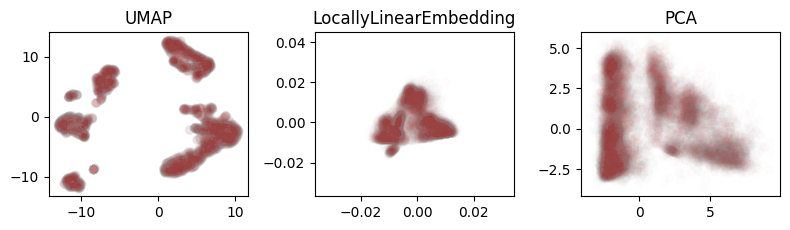

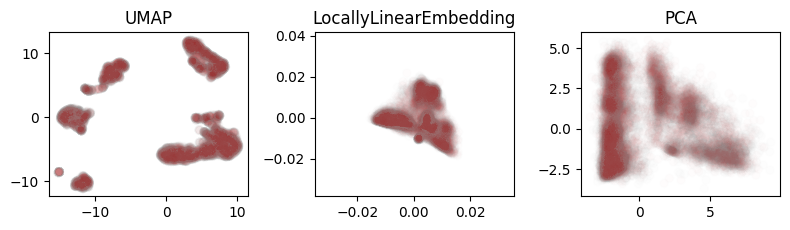

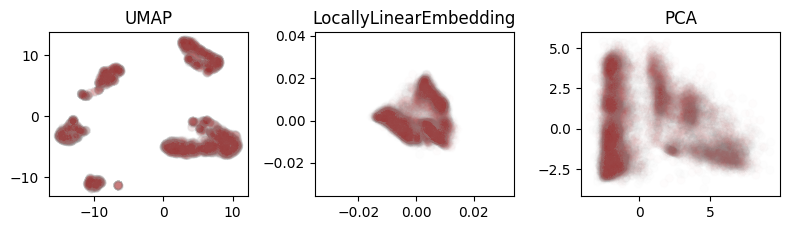

In [34]:
show_visualizations(vizzes1, y_sub, cmap='Set1', edgecolor='silver', alpha=0.01)
show_visualizations(vizzes2, y_sub, cmap='Set1', edgecolor='silver', alpha=0.01)
show_visualizations(vizzes3, y_sub, cmap='Set1', edgecolor='silver', alpha=0.01)

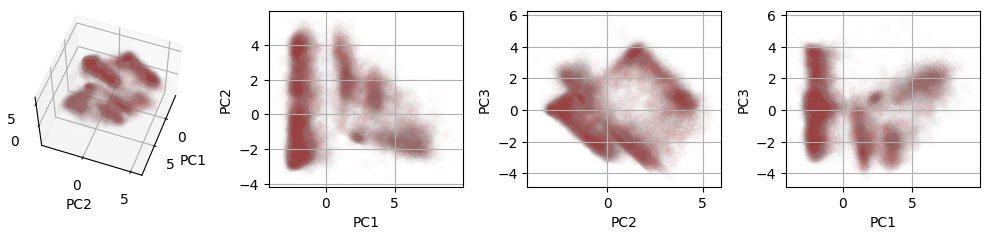

In [35]:
scatter2d3d(pd.DataFrame(PCA(3).fit_transform(X_sub), columns=['PC1', 'PC2', 'PC3']), (60,20), 
            c=y_sub, figsize=(10,2.5), edgecolor='silver', cmap='Set1', alpha=0.01)
plt.show()

### Dimensionlity reduction: Observations
All dimensionality reduction methods applied here are quite different from each other. UMAP is essentially doing a kind of spring system simulation on the data, LLE is a attempting to reconstruct points with a linear combination of the points neighbors, while PCA is a matrix factorization method. The results are quite different, but UMAP is the one particularly designed for dimensionality reductions.  

Inspecting the three plots shows that UMAP did actually not change that much with the number of neighbors. LLE however noticeable changes with respect to the number of neighbors, getting clearer and clearer clusterings with higher amounts of neighbors. PCA was just included in all three visualization for consistency.

- UMAP: Seemingly shows 7 clusters (including the really small ones), but some of them are quite small and may be caused by random factors. 

- LocallyLinearEmbedding: Seemingly shows 2 (or 3?) clusters. Does not give so much.

- PCA: Shows 5 to 7 relatively crowded areas.

The three different dimensionality reduction suggests that the number of clusters are between 2 and 7. 



# Task 3 - Clustering

The candidate clustering algorithms are:
- Spectral Clustering
- HDBSCAN
- Agglomerative Clustering
- Kmeans
- MeanShift

In [36]:
est_bw = estimate_bandwidth(X_sub)
print(f'Estimated bandwidth = {est_bw}')

Estimated bandwidth = 4.802873287022478


### Reference for hyperparameters
There will be done a hyperparameter search, where each clustering algorithm will be tested for one important hyperparameter each. This is done to reduce the computation times and makes it somewhat easier to plot and compare as well. The non-rich clusterings such as Kmeans and Spectral Clustering will be with different numbers of clusters. The clusterings that does not need a fixed number of clusters will then be tested for other important hyperparameters such as bandwidth for MeanShift and minimum cluster size for HDBSCAN.  

- The minimum cluster size for HDBSCAN will simply be values between 50 and 300 just to cover a wide range. 

- For MeanShift, Sklearns estimate_bandwidth function will be used as a reference,then the candidate bandwidths will be values around that.  

- For Spectral Clustering, Agglomerative Clustering and KMeans, the number of clusters seems to lie between 5 and 7, so the number of clusters to test will bee between 4 and 8 just in case the visual representation does not show enough. 

In [ ]:
# Candidate parameters
candkwargs_list = [
    dict(min_cluster_size=[50, 100, 150, 200, 250, 300]),#HDBSCAN
    dict(bandwidth=[3.6, 4.0, 4.4, 4.8]),                #MeanShift
    dict(n_clusters=[4,5,6,7,8]),                        #Spectral Clustering
    dict(n_clusters=[4,5,6,7,8]),                        #Agglomerative Clustering
    dict(n_clusters=[4,5,6,7,8])                         #Kmeans
]

clusterers = [HDBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, KMeans]

## Internal validation
There will be three different scorings in order to have diversity in the scorings. One can interpret this as having three different judges for the algorithms. The scorings are Silhouette score, SD score and Davies-Bouldin score. All the score types are of course internal scores, and all of them are chosen because they are made to score clusterings but in different ways (in other words the behaviors of judges). 


In [ ]:
def sd(X, labels) -> float:
    '''sd score'''
    unique_labels = np.unique(labels)
    scat = np.mean([np.linalg.norm(np.var(X[labels==lab], axis=0)) 
                    for lab in unique_labels]) / np.linalg.norm(np.var(X, axis=0))
    
    centers = np.array([np.mean(X[labels==lab], axis=0) for lab in unique_labels])
    center_dists = pdist(centers)
    dis = np.sum(1/np.sum(squareform(center_dists), axis = 0)) * np.max(center_dists) / np.min(center_dists)
    return scat + dis

In [ ]:
scorers = [silhouette_score, sd, davies_bouldin_score]

In [ ]:
def multi_hyperparam_search(X:np.ndarray, clusterers: list, kwargs_list: list, scorers: list) -> tuple:
    '''
    Does hyperparameter search for multiple clustering algorithms. Also takes in a list of 
    scoring algorithms e.g. sd(). The return values are three things:
    
    A dataframe containing the performances of algorithms 
    A list of all the fitted objects
    A list of all the clusterings from all algorithms. 
    '''
    # Initialize a list for the scorers
    scorers_dict = {name(scorer):[] for scorer in scorers}
    instance_column = []
    cluster_results = []
    param_vals = []
    scoretimes = []
    runtimes = []
    clusterer_instances = []
    y_preds = []

    for clusterer, params in zip(clusterers, kwargs_list):
        t0 = time.time()
        pg = list(ParameterGrid(param_grid=params))
        param_results = []
        
        for param in pg:
            print(f'Running {name(clusterer)} with {param}', end=' ')

            t0_fit = time.time()
            model = clusterer(**param)
            y_pred = model.fit_predict(X)
            runtimes.append(time.time() - t0_fit)
            print(f'took {runtimes[-1]:.2f} s')

            param_vals.append(param)
            clusterer_instances.append(model)
            instance_column.append(name(clusterer))
            y_preds.append(y_pred)

            for scorer in scorers:
                try:
                    score_result = scorer(X, y_pred)
                except ValueError:
                    print(f'{name(clusterer)} with {param} got 1 cluster, score is representad as np.nan')
                    score_result = np.nan
                    
                scorers_dict[name(scorer)].append(score_result)

        scoretimes.append(time.time()-t0)

    # Add these things to the dict
    scorers_dict['runtimes'] = runtimes
    scorers_dict['params'] = param_vals
    scorers_dict['instances'] = instance_column

    # Daatframe the thing
    return pd.DataFrame(scorers_dict), np.array(clusterer_instances), np.array(y_preds)

In [41]:
df_hyperparams, models, model_preds = multi_hyperparam_search(X_sub, clusterers, candkwargs_list, scorers)

Running HDBSCAN with {'min_cluster_size': 50} took 5.59 s
Running HDBSCAN with {'min_cluster_size': 100} took 6.99 s
Running HDBSCAN with {'min_cluster_size': 150} took 5.66 s
Running HDBSCAN with {'min_cluster_size': 200} took 6.27 s
Running HDBSCAN with {'min_cluster_size': 250} took 6.53 s
Running HDBSCAN with {'min_cluster_size': 300} took 6.23 s
Running MeanShift with {'bandwidth': 3.6} took 243.53 s
Running MeanShift with {'bandwidth': 4.0} took 253.40 s
Running MeanShift with {'bandwidth': 4.4} took 487.04 s
Running MeanShift with {'bandwidth': 4.8} took 693.12 s
Running SpectralClustering with {'n_clusters': 4} took 622.32 s
Running SpectralClustering with {'n_clusters': 5} took 533.48 s
Running SpectralClustering with {'n_clusters': 6} took 341.69 s
Running SpectralClustering with {'n_clusters': 7} took 324.45 s
Running SpectralClustering with {'n_clusters': 8} took 308.32 s
Running AgglomerativeClustering with {'n_clusters': 4} took 21.83 s
Running AgglomerativeClustering wit

In [42]:
print_html(df_hyperparams)

,silhouette_score,sd,davies_bouldin_score,runtimes,params,instances
0,0.303561,0.881941,1.499205,5.585709,{'min_cluster_size': 50},HDBSCAN
1,0.333670,0.884910,1.507384,6.991016,{'min_cluster_size': 100},HDBSCAN
2,0.339531,0.879430,1.499745,5.663110,{'min_cluster_size': 150},HDBSCAN
3,0.339032,0.872899,1.491455,6.271500,{'min_cluster_size': 200},HDBSCAN
4,0.328129,0.947169,1.533851,6.529388,{'min_cluster_size': 250},HDBSCAN
5,0.326819,0.938445,1.518569,6.230063,{'min_cluster_size': 300},HDBSCAN
6,0.454295,0.965800,1.345980,243.527839,{'bandwidth': 3.6},MeanShift
7,0.457106,0.844500,1.071917,253.404308,{'bandwidth': 4.0},MeanShift
8,0.313554,1.068698,1.362886,487.040416,{'bandwidth': 4.4},MeanShift
9,0.398010,1.188940,1.204048,693.123349,{'bandwidth': 4.8},MeanShift


In [ ]:
def plot_compare_clusterings2(df: pd.DataFrame, hier: list = ['instances','params'], 
                              title: str = 'Comparison', captions: Union[tuple, bool]=False, **kwargs) -> None:
    '''
    Takes in a pandas DataFrame that is essentially has information for a 2 level
    hierarchical index. The columns that makes the hierarchical index is specified 
    in the "hier" parameter. Rest of columns are then interpeted as scorings. 
    Plots are then generated accodingly. 

    ONLY WORKS FOR SINGLE PARAMETERS
    '''
    df = df.copy()
    plot_columns = list(df.columns)
    [plot_columns.remove(idx) for idx in hier]
    
    # Get unique types of parameters, e.g. n_clusters and bandwidths are two 
    # unique types
    param_types = df[hier[1]].apply(lambda x: tuple(x.keys())[0]).unique()

    n_plots = len(plot_columns)
    n_paramtypes = len(param_types)

    # Parameter category mask. Used to select out the right rows with respect
    # to a parameter
    df_temp = pd.DataFrame()
    for param_type in param_types:
        df_temp[param_type] = df[hier[1]].apply(lambda x: str(*x.keys()) == param_type)

    fig, axes = plt.subplots(n_paramtypes, n_plots, figsize=(3*n_plots, 1.7*n_paramtypes))

    for i, param_type in zip(np.arange(n_paramtypes), param_types):
        # Sort out plot information with respect to parameter type
        df_curr = df[df_temp[param_type]].copy()
        # Extract values 
        df_curr[hier[1]] = df_curr[hier[1]].apply(lambda x: tuple(x.values())[0])
        df_curr.rename(columns={hier[1]:param_type}, inplace=True)
        
        stacked = df_curr.set_index([hier[0], param_type]).stack()
        # Different algorithms using the parameter
        algos = stacked.index.unique(hier[0])

        # To be honest I did not comment so much when coding all of this, I dont 
        # really understand it anymore. It works well though!
        for j, ax, score_type in zip(np.arange(len(axes[i,:])), axes[i,:], plot_columns):
            for algo in algos:
                ax.plot(stacked[algo].unstack()[score_type], **kwargs)
            ax.grid(linewidth=0.2)
            ax.set_xticks(stacked[algo].unstack()[score_type].index)
        
        axes[i,-1].legend(algos, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.setp(axes[i], xlabel=param_type)
    
    [ax.set_title(score_type, fontweight='bold', fontsize=10) for score_type, ax in zip(plot_columns, axes.ravel())]
    if captions:
        for i, ax in enumerate(axes[-1]):
            ax.text(
                x=0.5, 
                y=-0.6, 
                s=captions[i], 
                horizontalalignment='center', 
                verticalalignment='center', 
                transform=ax.transAxes,
                fontsize=10)

    fig.suptitle(title)
    fig.tight_layout()
    fig.show()        

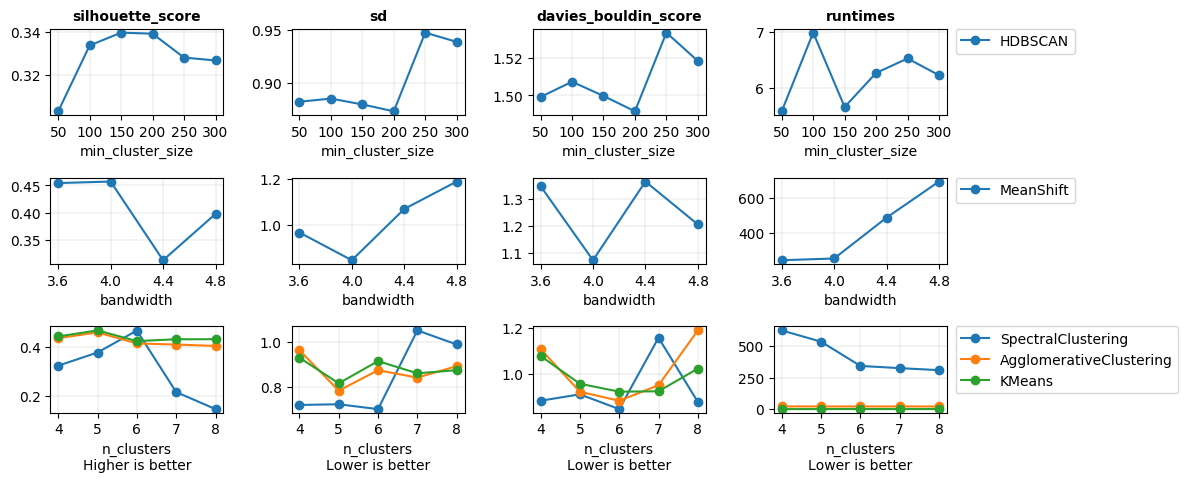

In [44]:
plot_compare_clusterings2(df_hyperparams, marker='o', title=None, captions=['Higher is better', 'Lower is better', 'Lower is better', 'Lower is better'])

In [45]:
def get_best_indices(df: pd.DataFrame, target: str, score_type: str, select_max: bool = True):
    '''
    Given a dataframe like the df_hyperparams above, extract the index with best score.
    '''
    algos = df[target].unique()
    indices = []

    if select_max:
        [indices.append(df[df[target] == algo][score_type].idxmax()) for algo in algos]
    else:
        [indices.append(df[df[target] == algo][score_type].idxmin()) for algo in algos]

    return df.loc[indices].sort_values(by=score_type, ascending=not select_max)[[target, 'params', score_type]], indices

def mvps(df: pd.DataFrame, hier=['instances','params'], minmax: list = True) -> tuple:
    '''
    Obtain most valuable player from dataframe. Minmax is a dict with info 
    if score type is best when low or high
    '''
    df = df.copy()
    plot_columns = list(df.columns)
    [plot_columns.remove(idx) for idx in hier]

    dfs = []
    dicto = {}
    for score_type in plot_columns:
        df_curr, dicto[score_type] = get_best_indices(df, hier[0], score_type, select_max=minmax[score_type])
        print(f'Performances with respect to {score_type}:', end='\n    ')
        dfs.append(df_curr)
        print_html(df_curr)
        print()
    
    return dicto, dfs

dict_idx, dfs = mvps(df_hyperparams, minmax=dict(silhouette_score=1,
                                            sd=0,
                                            davies_bouldin_score=0,
                                            runtimes=0))

Performances with respect to silhouette_score:
    

,instances,params,silhouette_score
21,KMeans,{'n_clusters': 5},0.465553
12,SpectralClustering,{'n_clusters': 6},0.465079
16,AgglomerativeClustering,{'n_clusters': 5},0.457609
7,MeanShift,{'bandwidth': 4.0},0.457106
2,HDBSCAN,{'min_cluster_size': 150},0.339531



Performances with respect to sd:
    

,instances,params,sd
12,SpectralClustering,{'n_clusters': 6},0.698279
16,AgglomerativeClustering,{'n_clusters': 5},0.781241
21,KMeans,{'n_clusters': 5},0.814553
7,MeanShift,{'bandwidth': 4.0},0.844500
3,HDBSCAN,{'min_cluster_size': 200},0.872899



Performances with respect to davies_bouldin_score:
    

,instances,params,davies_bouldin_score
12,SpectralClustering,{'n_clusters': 6},0.845099
17,AgglomerativeClustering,{'n_clusters': 6},0.881554
22,KMeans,{'n_clusters': 6},0.921096
7,MeanShift,{'bandwidth': 4.0},1.071917
3,HDBSCAN,{'min_cluster_size': 200},1.491455



Performances with respect to runtimes:
    

,instances,params,runtimes
20,KMeans,{'n_clusters': 4},0.394608
0,HDBSCAN,{'min_cluster_size': 50},5.585709
19,AgglomerativeClustering,{'n_clusters': 8},21.298313
6,MeanShift,{'bandwidth': 3.6},243.527839
14,SpectralClustering,{'n_clusters': 8},308.321110


### Observations on internal scoring
Note: the tables above sorted by best scoring in ascending order, i.e. the top of the table shows the best performer.

The Spectral Clustering algorithm performs the best respective to SD and Davies-Bouldin (DB) scores, while KMeans is actually the one performing the best according to silhouette score (however, spectral clustering is very close). SD and DB are agreeing when it comes to ranking (although with different hyperparameters), and all the scorings agree on the top two and top three. Conveiniently, the top three cluster algorithms are Spectral Clustering, Agglomerative Clustering and KMeans. 

It is very important to note here that HDBSCAN has a very large disadvantage since it has noise points. For the scoring algorithms, the noise is viewed as an extremely bad cluster (very large and loosely connected, "close" to other clusters), thus ruining the scores for HDBSCAN. The correct ranking for HDBSCAN relative to the other clustering algorithms is ambigous. One can remove the noise points for all the clusterings, but then the HDBSCAN will have an upperhand as the noise points were determined by HDBSCAN itself. Just removing for HDBSCAN will definetively give HDBSCAN an upper hand, as the clusters becomes artificially well separated. For simplicity of this task, further use of HDBSCAN and its results will be ignored.

SpectralClustering {'n_clusters': 6}  unique clusters:  6


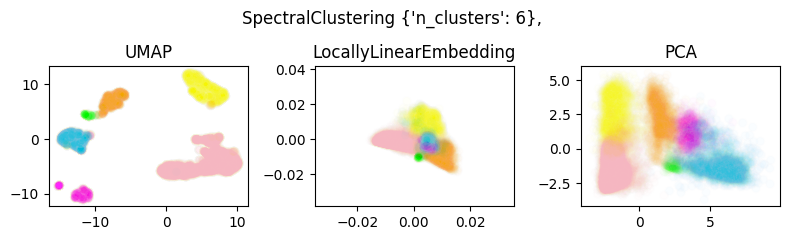


AgglomerativeClustering {'n_clusters': 5}  unique clusters:  5


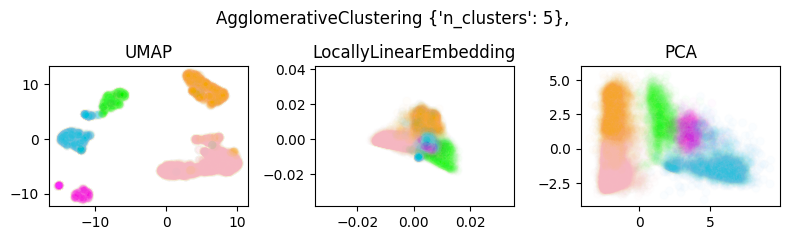


KMeans {'n_clusters': 5}  unique clusters:  5


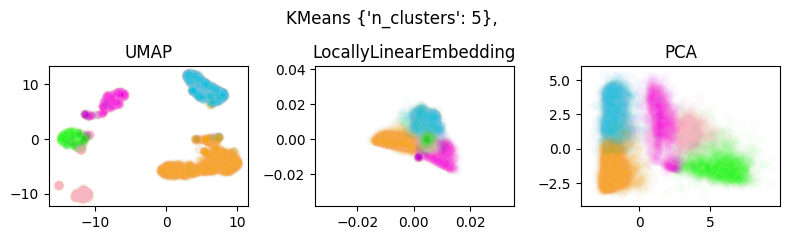


MeanShift {'bandwidth': 4.0}  unique clusters:  8


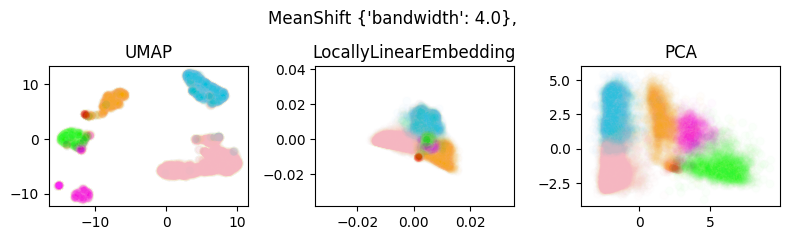


HDBSCAN {'min_cluster_size': 200}  unique clusters:  7


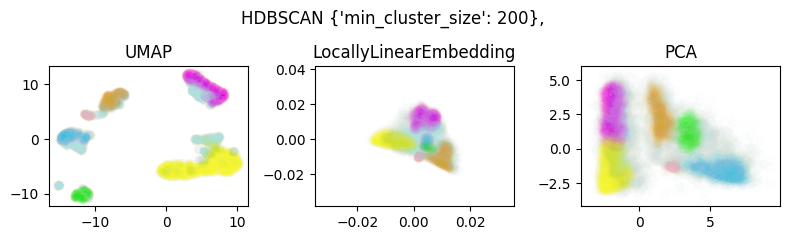

In [46]:
# target_df = dfs[0] # Respective to Silhouette
target_df = dfs[1] # Respective to SD 
# target_df = dfs[2] # Respective to Davies-Bouldin
colormap_func = lambda i: colors[i % len(colors)]

for idx, namae, param in zip(target_df.index.values, target_df['instances'].values, target_df['params']):
    unq_clusters_found = np.unique(model_preds[idx])
    print(namae, param, ' unique clusters: ',len(unq_clusters_found))
    show_visualizations(vizzes2, list(map(colormap_func, model_preds[idx])), title=namae+f' {param}, ', 
                        edgecolor='beige', alpha=0.02)
    print()


By visual inspection, all clustering algorithms are seemingly doing a reasonable job. None of them are partiularily bad, but the ones that stand out are Spectral Clustering and HDBSCAN. Those clusterings are very clean in the sense that they both manage to determine 6 clusters (excluding noise) and that the clusters looks quite pure. 

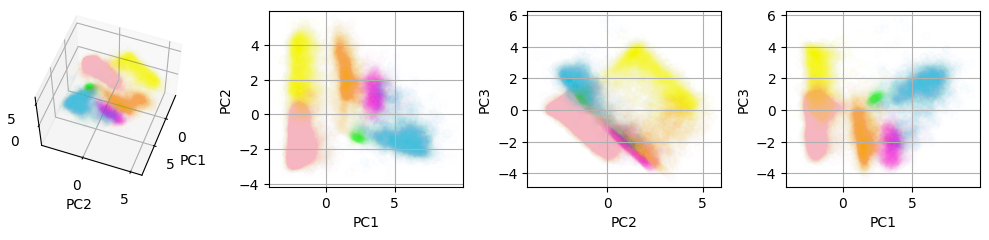

In [47]:
scatter2d3d(pd.DataFrame(PCA(3).fit_transform(X_sub), columns=['PC1', 'PC2', 'PC3']), (60,20), 
            c=list(map(colormap_func, model_preds[12])), figsize=(10,2.5), edgecolor='beige', cmap='Set1', alpha=0.01)
plt.show()

Also just try to plot PCA in 3 dimensions as it is very fast to calculate and that I have already created a function for this.

# Task 4 - External validation

In [ ]:
def get_dataset_from_clustering(ids: np.ndarray, cluster_labels: np.ndarray, class_labels: np.ndarray) -> tuple:
    '''
    Retrieves dataset from cluster labels. 
    '''
    unique_ids, freqs = np.unique(ids, return_counts=True)
    n_samples = len(unique_ids)
    n_clusters = len(np.unique(cluster_labels))

    dataset = np.zeros((n_samples, n_clusters))
    dataset_labels = np.zeros(n_samples)

    for i, sample_id, freq in zip(np.arange(n_samples), unique_ids, freqs):
        # Mask for cells that are respective to the current id
        id_mask = ids==sample_id

        unique_clusts_for_id, freqs_for_clusts_id = np.unique(cluster_labels[id_mask], return_counts=1)        
        dataset[i,unique_clusts_for_id] = freqs_for_clusts_id / freq        

        dataset_labels[i] = class_labels[id_mask][0]
    
    return dataset, dataset_labels

In [ ]:
def CrossValidate(model: Callable, candidates: dict, X_train: np.ndarray, y_train: np.ndarray, 
                folds: int = 5, verbose: bool=False):
    '''
    Uses sklearn.GridSeachCV, but also has some extra boilerplate code to give
    nicer prints
    '''
    gsc = GridSearchCV(estimator=model,
                       param_grid=candidates, 
                       scoring='roc_auc',
                       n_jobs=6, # Parallelize CV-process
                       cv=folds,
                       iid=False,
                       verbose=0)

    gsc.fit(X_train, y_train)
    
    df = pd.DataFrame(dict(
        mean_score=gsc.cv_results_['mean_test_score'],
        mean_fit_time=gsc.cv_results_['mean_fit_time'], 
        mean_score_time=gsc.cv_results_['mean_score_time'], 
        parameters=gsc.cv_results_['params']))

    if verbose:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                                'display.max_colwidth', -1):
            print()
            
            if verbose > 1:
                print(f'''
                ---- {name(gsc)} results for: {name(model)} ----
                ''')
                
                print(df)
                
            print(f'''
            ----- Best configuration for {name(model)} -----
            ''')    
            print_html(df.loc[[gsc.best_index_]])
            
    return gsc.best_estimator_, gsc.best_params_, gsc.best_score_, df

In [ ]:
clusters_idx = model_preds[12]
X_dataset, y_dataset = get_dataset_from_clustering(ids_sub, clusters_idx, y_sub)

Class 0 is lightpink
Class 1 is deepskyblue


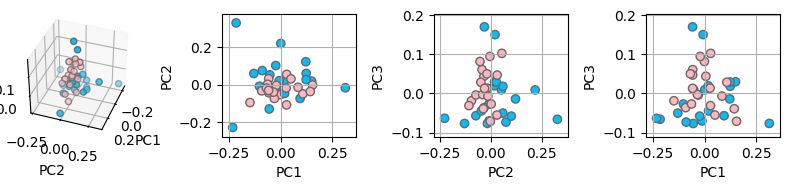

In [51]:
print(f'Class 0 is {colors[0]}')
print(f'Class 1 is {colors[1]}')

scatter2d3d(pd.DataFrame(PCA(3).fit_transform(X_dataset), columns=['PC1', 'PC2', 'PC3']), (40,20), 
            c=list(map(colormap_func, y_dataset.astype(int))), figsize=(8,2), edgecolor='dimgrey', cmap='Set1')
plt.show()

In [52]:
X_rest, X_test, y_rest, y_test = train_test_split(X_dataset, y_dataset, test_size=10, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=10, random_state=seed)

print(f'Train size: {len(y_train)}')
print(f'Validation size: {len(y_val)}')
print(f'Test size: {len(y_test)}')

Train size: 20
Validation size: 10
Test size: 10


The chosen candidate classifiers Random Forest and K-Neighbors-Classifier as they are relatively easy to tune, and that they do not assume any shape for the data. They are generally quite versatile. 

The dataset is very small, so the candidate hyperparameters for the Random Forest is with a small number of estimators, and hyperparameters such that the trees gets pre-pruned.

kNN is relatively easy to tune as the most central hyperparameter is number of neighbors. But weighted and unweighted will be tested as well. 

In [ ]:
classifier_models = [RandomForestClassifier(random_state=seed), KNeighborsClassifier()]

classifier_candwargs = [
    dict(n_estimators=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], min_samples_leaf=[1,3,5], min_samples_split=[2,3,4,5], max_depth=[2,3,4,5,None]), 
    dict(n_neighbors=[1,2,3,4,5,6], weights=['uniform','distance'])]

Do a 3-fold gridsearch to tune hyperparameters. It could be argued that should maybe use more folds to reduce variance. The dataset is so small that having, say 10 folds, will results in very sparse folds. 

In [54]:
best_model_dict = {}
for cmodel, candkwargs in zip(classifier_models, classifier_candwargs):
    estimator, params, best_score, df_history = CrossValidate(cmodel, candkwargs, X_train, y_train, verbose=1, folds=3)
    best_model_dict[name(estimator)] = estimator
    print('\n')



            ----- Best configuration for RandomForestClassifier -----
            


,mean_score,mean_fit_time,mean_score_time,parameters
19,0.827778,0.044895,0.011364,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10}"






            ----- Best configuration for KNeighborsClassifier -----
            


,mean_score,mean_fit_time,mean_score_time,parameters
7,0.680556,0.000856,0.00641,"{'n_neighbors': 4, 'weights': 'distance'}"


In [55]:
validation_aucs = []
for model_name, model_obj in best_model_dict.items():
    print(f'Validating {model_name}', end=' ')
    y_softpred = model_obj.predict_proba(X_val)[:,1]
    validation_aucs.append(roc_auc_score(y_val, y_softpred))
    print(f'-> AUC = {validation_aucs[-1]}')

best_val_idx = np.argmax(validation_aucs)
winner_name = list(best_model_dict.keys())[best_val_idx]
print(f'\nBest in validation step is {winner_name}')
winner_obj = best_model_dict[winner_name] 

Validating RandomForestClassifier -> AUC = 0.8333333333333334
Validating KNeighborsClassifier -> AUC = 0.7291666666666667

Best in validation step is RandomForestClassifier


Train the winner of validation step with the training and validation data, then score again on test data.

In [ ]:
winner_obj.random_state=seed
winner_obj.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))

winner_pred_proba = winner_obj.predict_proba(X_test)[:,1]
winner_pred_hard = winner_obj.predict(X_test)

winner_auc = roc_auc_score(y_test, winner_pred_proba)
winner_acc = accuracy_score(y_test, winner_pred_hard)

In [57]:
print(f'{winner_name} AUC on test set is {winner_auc:.2f}')
print(f'{winner_name} accuracy on test set is {winner_acc:.2f}')

RandomForestClassifier AUC on test set is 0.55
RandomForestClassifier accuracy on test set is 0.70
